# DSCI 310: Airbnb Price Analysis
Group Members; Oliver Gullery, Prithvi Sureka, Riddhi Battu, Rashi Selarka


In [268]:
# dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
import folium

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xg
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
import requests
from branca.colormap import linear
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_validate
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# 1. Summary/Introduction -> Needs more...
The aim of this data analysis project is to identify which of the factors in the Airbnb Dataset are strong predictors of price. Doing so will allow us obtain information which can determine if Airbnbs are accurately priced. 

### 1.1 Loading / Exporting Data to csv

In [236]:
# loading the data
url_listings = "http://data.insideairbnb.com/united-states/ny/new-york-city/2023-12-04/visualisations/listings.csv"

data = pd.read_csv(url_listings)
data.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2595,Rental unit in New York · ★4.68 · Studio · 1 b...,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,240,30,49,2022-06-21,0.29,3,339,0,NaN
1,5121,Rental unit in Brooklyn · ★4.52 · 1 bedroom · ...,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,66,30,50,2019-12-02,0.28,2,88,0,NaN
2,6848,Rental unit in Brooklyn · ★4.58 · 2 bedrooms ·...,15991,Allen & Irina,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,81,30,191,2023-08-14,1.08,1,142,4,NaN


In [237]:
data.to_csv("../data/raw/airbnb_data_2023")

## 2. Exploratory Data Analysis

In [238]:
# Data shape & datatypes
print(f'Data Shape: {data.shape}\n')
print(f'Data datatypes: \n{data.dtypes}')

Data Shape: (39627, 18)

Data datatypes: 
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object


#### 2.1 Summary Statistics

In [239]:
data.info()

data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39627 entries, 0 to 39626
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39627 non-null  int64  
 1   name                            39627 non-null  object 
 2   host_id                         39627 non-null  int64  
 3   host_name                       39612 non-null  object 
 4   neighbourhood_group             39627 non-null  object 
 5   neighbourhood                   39627 non-null  object 
 6   latitude                        39627 non-null  float64
 7   longitude                       39627 non-null  float64
 8   room_type                       39627 non-null  object 
 9   price                           39627 non-null  int64  
 10  minimum_nights                  39627 non-null  int64  
 11  number_of_reviews               39627 non-null  int64  
 12  last_review                     

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,3.962700e+04,3.962700e+04,39627.000000,39627.000000,39627.000000,39627.000000,39627.000000,28147.000000,39627.000000,39627.000000,39627.000000
mean,3.083450e+17,1.602573e+08,40.729360,-73.946072,208.816464,30.051127,25.251520,1.021708,41.852197,153.721276,6.264088
std,4.050888e+17,1.717839e+08,0.056425,0.054788,482.380712,29.290027,57.718207,1.716199,124.056880,147.391076,16.602446
min,2.595000e+03,1.678000e+03,40.500314,-74.251907,8.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,2.023932e+07,1.692691e+07,40.688980,-73.982785,75.000000,30.000000,0.000000,0.110000,1.000000,0.000000,0.000000
50%,4.650264e+07,8.066903e+07,40.726520,-73.954090,127.000000,30.000000,4.000000,0.390000,1.000000,122.000000,0.000000
75%,7.564324e+17,2.857275e+08,40.762667,-73.926560,214.000000,30.000000,22.000000,1.415000,6.000000,319.000000,4.000000
max,1.037983e+18,5.491316e+08,40.911380,-73.713650,30000.000000,1250.000000,1857.000000,71.160000,691.000000,365.000000,983.000000


#### 2.2 Identifying Null Values & Duplicates

In [240]:
print(f'Null Values: {data.isna().sum()}\n')
print(f'Duplicated Values: {data.duplicated().sum()}')

Null Values: id                                    0
name                                  0
host_id                               0
host_name                            15
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       11480
reviews_per_month                 11480
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           35268
dtype: int64

Duplicated Values: 0


In [241]:
# minor statistics about License
print(f'License Summary Statistics: \n{data["license"].describe()}')



License Summary Statistics: 
count       4359
unique       700
top       Exempt
freq        3408
Name: license, dtype: object


#### 2.3 Numerical Data Correlations (Top 10)

In [242]:
# creating correlation matrix from numeric data (exlucding host_id and id)
corr_matrix = data.select_dtypes('int64').drop(['host_id','id'], axis=1).corr()

def rank_correlations(corr_matrix):
    # flattening matrix
    flattened_matrix = corr_matrix.stack().reset_index()

    #renaming columns
    flattened_matrix.columns = ['Variable_1', 'Variable_2', 'Correlation']

    # removing duplicate variable names
    flattened_matrix = flattened_matrix.loc[flattened_matrix['Variable_1'] != flattened_matrix['Variable_2']]

    corr_column = flattened_matrix['Correlation']

    flattened_matrix = flattened_matrix.iloc[abs(corr_column).argsort()[::-1]]

    flattened_matrix = flattened_matrix.loc[flattened_matrix['Correlation'].duplicated()]


    print(f'Top 10 Variable Correlations: \n{flattened_matrix.head(10)}')

rank_correlations(corr_matrix)

Top 10 Variable Correlations: 
                        Variable_1                      Variable_2  \
32           number_of_reviews_ltm               number_of_reviews   
22  calculated_host_listings_count                availability_365   
20  calculated_host_listings_count               number_of_reviews   
33           number_of_reviews_ltm  calculated_host_listings_count   
29                availability_365           number_of_reviews_ltm   
31           number_of_reviews_ltm                  minimum_nights   
4                            price                availability_365   
16               number_of_reviews                availability_365   
13               number_of_reviews                  minimum_nights   
1                            price                  minimum_nights   

    Correlation  
32     0.645866  
22     0.137655  
20    -0.129957  
33    -0.109144  
29     0.084703  
31    -0.075249  
4      0.065750  
16     0.053723  
13    -0.052535  
1     -0.046154  


## 2.4 Takwaways From Preliminary EDA
- Our shape function tells us we have 39627 rows and 18 features which includes our target variable `price`. 

- Looking at the columns from our info() function we can identify that name is a text data which could provide some valuable insights. We can also infer that any id information (`id` and `host_id`) and variables such as `host_name` will not provide any key information, thus, we can drop them for our data analysis.

- The describe() function provided key summary statistics for our numerical columns which included the following metrics: count, mean, standard deviation, minimum, and maximum. This helps us better understand the spread of our data. Our info() function gave us further information about the datatypes, columns, and amount of data we have. Through this analysis in addition to our dtypes() function we can identify that `last_review` is an object dtype but could be converted into a pandas datatime format to further utilize pandas datatime capabilities. Examples of such would be splitting the data into year, month and day to identify if there are any temporal patterns across months of years. 

- Our isna() function informed us of the null values which are included in the dataset. The columns `host_name` has *15* null values but this is irrelevant as we will drop this column. Our `reviews_per_month` column and `last_review` column have *11480* null values each. This suggests that when a airbnb listing doesn't have a review, it was listed as a null value in the data. To fix this we could impute 0 into reviews per month. For `last_review`, we decided it would be appropriate to drop the column as some of the information it provides is stored in reviews per month. 

- `license` has a significant number of null values with 35268. It might however provide some interesting insights into price as a license is proof that the airbnb owners comply with the regulatory standards. The nature of these missing values is unknown, thus, we cannot be sure if the null values means the listing has no license. Due to this imbalance in the data, we thought it would be best to drop this column, however, it could be worth exploring the relationship between license and other variables in future analysis. 


### 2.5 Summary
In order to prepare our data for further analysis we must perform some preliminary feature engineering which will involve:
- Convert `id` and `host_id` into object datatypes to prepare them to be dropped.
- Imputing zeros into the `reviews_per_month` null values
- Separate data into target column, categorical, numerical, text data, and drop data. 
- Splitting data into training and testing data

## 3. Preliminary Feature Engineering

3.1 **Convert `id` and `host_id` into object datatypes to prepare them to be dropped.**

In [243]:
data['id'] = str(data['id'])
data['host_id'] = str(data['host_id'])

3.2 **Impute zeros into the `reviews_per_month` column for null values.**

In [244]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

3.3 Separating Data into target column, categorical, numerical, text, and drop data

In [245]:
# target column
target_data = ['price']

# numeric data
numerical_data = data.select_dtypes(include=["int64", "float64"]).drop(target_data, axis=1)
numerical_data = numerical_data.columns

# text data
text_data = ["name"]

# drop data
drop_data = ["host_name", "host_id", "id", "license", "last_review"]

# Categorical Data
categorical_data = data.select_dtypes(include=["object"])
categorical_data = categorical_data.columns
columns_to_exclude = text_data + drop_data
categorical_data = [col for col in categorical_data if col not in columns_to_exclude]


print(f"Target Column: {target_data}\n")
print(f"Numerical Columns: {numerical_data}\n")
print(f"Categorical Columns: {categorical_data}\n")
print(f"Text Data: {text_data}\n")
print(f"Drop Columns: {drop_data}\n")

Target Column: ['price']

Numerical Columns: Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm'],
      dtype='object')

Categorical Columns: ['neighbourhood_group', 'neighbourhood', 'room_type']

Text Data: ['name']

Drop Columns: ['host_name', 'host_id', 'id', 'license', 'last_review']



3.4 Splitting Data into test, train sets

In [246]:
train_df, test_df = train_test_split(data, test_size=0.2, shuffle=True)

X_train = train_df.drop(['price'], axis=1)
y_train = train_df['price']
X_test = test_df.drop(['price'], axis=1)
y_test = test_df['price']

print(f'Train Shape: {train_df.shape}\nTest Shape: {test_df.shape}\n')

print(f'Input Variables (includes drop data): {X_train.columns}\n')
print(f'Target Variable: {y_train.name}\n')

Train Shape: (31701, 18)
Test Shape: (7926, 18)

Input Variables (includes drop data): Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

Target Variable: price



# 4. Exploratory Data Analysis (Visualizations) 

**Figure 1. Map with Distribution of Listings by Location and Price**

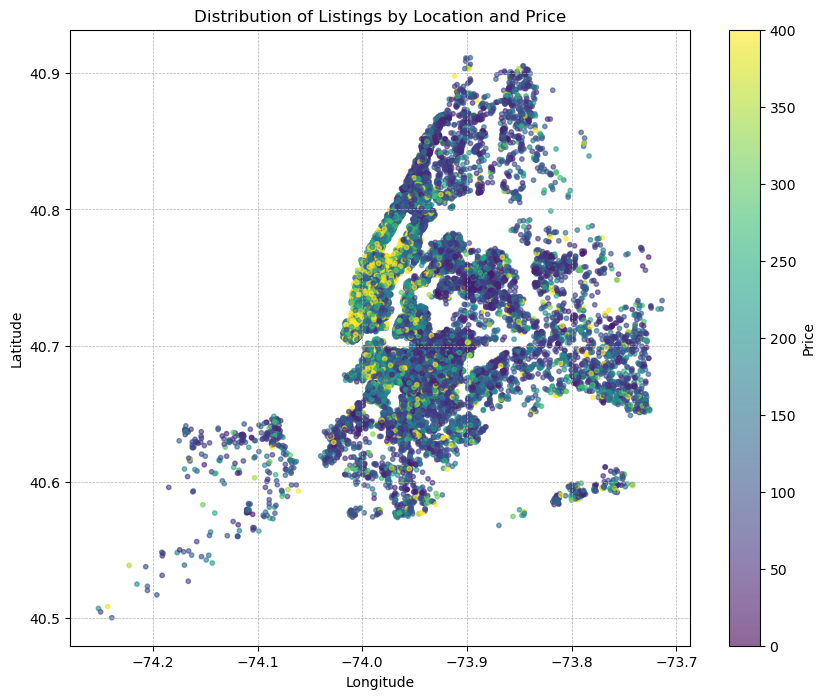

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [247]:
plt.figure(figsize=(10, 8))

# Setting color limits to more typical range, e.g., 0 to 400
# Adjust these values based on your specific dataset and its distribution
vmin, vmax = 0, 400

sc = plt.scatter(train_df['longitude'], train_df['latitude'], c=train_df['price'], cmap='viridis', s=10, alpha=0.6, vmin=vmin, vmax=vmax)
plt.colorbar(sc, label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of Listings by Location and Price')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
plt.figure(figsize=(10, 8))

**Figure 2. Price vs Number of Reviews Coloured by Room Type Scatterplot**

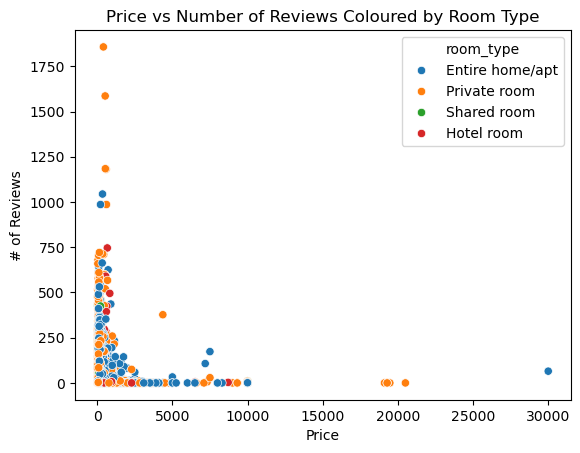

In [248]:
sns.scatterplot(train_df, x = 'price', y='number_of_reviews', hue='room_type')
plt.title("Price vs Number of Reviews Coloured by Room Type")
plt.xlabel("Price")
plt.ylabel("# of Reviews")
plt.show()

**Figure 3. Price vs Reviews Per Month Coloured by Room Type Scatterplot**

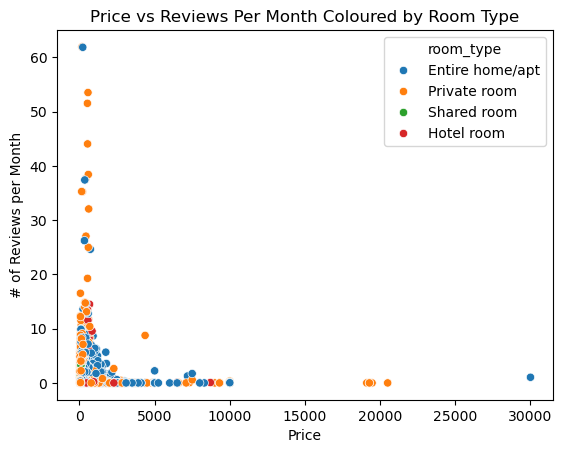

In [249]:
sns.scatterplot(train_df, x = 'price', y='reviews_per_month', hue='room_type')
plt.title("Price vs Reviews Per Month Coloured by Room Type")
plt.xlabel("Price")
plt.ylabel("# of Reviews per Month")
plt.show()

**Figure 4. Neighbourhood Group vs Log Scaled Price Coloured Boxplot**

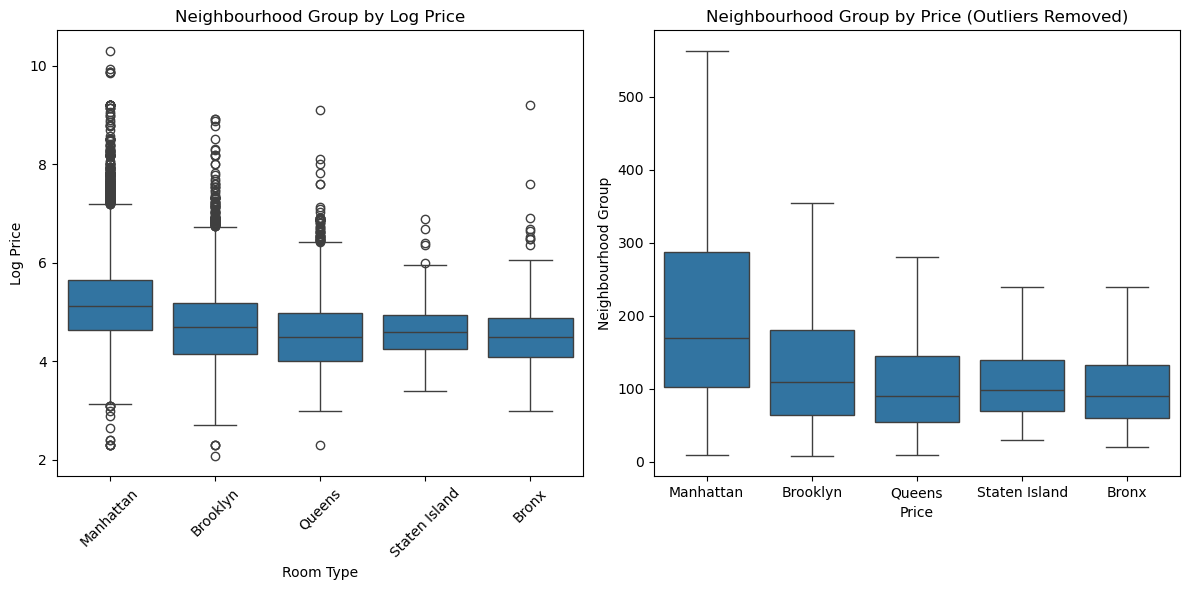

In [250]:
log_price = np.log(train_df['price'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# fig 1
sns.boxplot(x='neighbourhood_group', y=log_price, data=train_df, ax=axes[0])
axes[0].set_title('Neighbourhood Group by Log Price')
axes[0].set_xlabel('Room Type')
axes[0].set_ylabel('Log Price')
axes[0].tick_params(axis='x', rotation=45)
# fig 2
sns.boxplot(x='neighbourhood_group', y='price', data=train_df, showfliers=False, ax=axes[1])
axes[1].set_title('Neighbourhood Group by Price (Outliers Removed)')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Neighbourhood Group')

plt.tight_layout() 
plt.show()

**Figure 5. Room Type Vs Price Box plot**

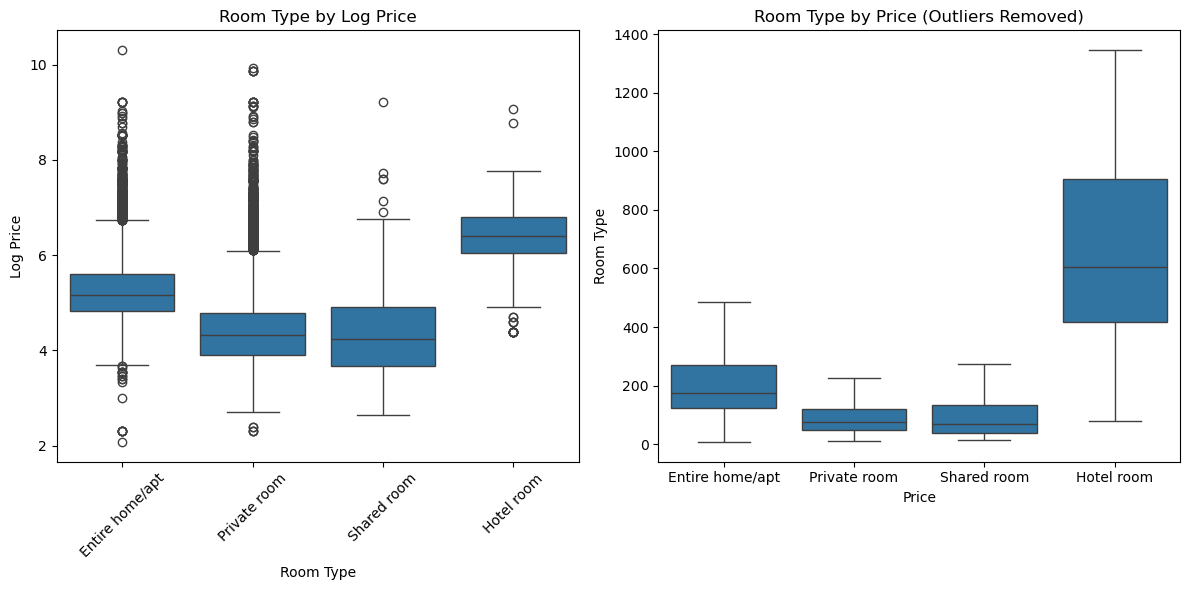

In [251]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# fig 1
sns.boxplot(x='room_type', y=log_price, data=train_df, ax=axes[0])
axes[0].set_title('Room Type by Log Price')
axes[0].set_xlabel('Room Type')
axes[0].set_ylabel('Log Price')
axes[0].tick_params(axis='x', rotation=45)
# fig 2
sns.boxplot(x='room_type', y='price', data=train_df, showfliers=False, ax=axes[1])
axes[1].set_title('Room Type by Price (Outliers Removed)')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Room Type')


plt.tight_layout()  
plt.show()

# 5. Preprocessing & Transformations

**5.1 Defining Transformations & Preparing Data**

In [252]:
# Numerical Transformer
numerical_transformer = StandardScaler()

# Categorical Transformer
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Text Data Transformer
text_transformer = CountVectorizer()

In [253]:
# target column
target_data = ['price']

# numeric data
numerical_data = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm']

# text data
text_data = "name"

# drop data
drop_data = ["host_name", "host_id", "id", "license", "last_review"]

# Categorical Data
categorical_data = ['neighbourhood_group', 'neighbourhood', 'room_type']
X_train[text_data].head(3)

3112     Rental unit in New York · ★4.55 · 3 bedrooms ·...
13979    Rental unit in Brooklyn · 1 bedroom · 1 bed · ...
15127    Rental unit in New York · ★5.0 · 2 bedrooms · ...
Name: name, dtype: object

5.2 Making Our Preprocessor

In [254]:
preprocessor = make_column_transformer(
    (numerical_transformer, numerical_data),
    (categorical_transformer, categorical_data),
    (text_transformer, text_data),
    remainder='drop'
)

**5.3 Implementing a Baseline Model**
We can implement a Dummy Regressor model as a baseline to assess our model with. 

In [255]:
dummy_model = DummyRegressor()

dummy_pipe = make_pipeline(preprocessor, dummy_model)
dummy_pipe.fit(X_train, y_train)
# dummy_predictions = dummy_pipe.predict(X_test)
f'Test Score is: {dummy_pipe.score(X_test, y_test)}'



'Test Score is: -1.1950582464281823e-05'

# Building Model

To being we will build a model using Ridge Regression

In [281]:
def eval_model(model, X_train, y_train, return_train_score=True):
    """
    Evaluates the model using cross validation scores 
    """
    scores = cross_validate(model, X_train, y_train, return_train_score=return_train_score)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [282]:
ridge_pipe = make_pipeline(preprocessor, Ridge())

ridge_model = ridge_pipe.fit(X_train, y_train)


eval_model(ridge_model, X_train, y_train)

/var/folders/fy/1_r80v9j3s39nw5nw46_dw800000gq/T/ipykernel_2186/3468493226.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


fit_time       0.497 (+/- 0.038)
score_time     0.051 (+/- 0.002)
test_score     0.151 (+/- 0.052)
train_score    0.165 (+/- 0.021)
dtype: object

In [286]:
xg = xgb.XGBRegressor()

xg_pipe = make_pipeline(preprocessor, xg)

xg_model = xg_pipe.fit(X_train, y_train)

eval_model(xg_model, X_train, y_train)

/var/folders/fy/1_r80v9j3s39nw5nw46_dw800000gq/T/ipykernel_2186/3468493226.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


fit_time       0.449 (+/- 0.060)
score_time     0.057 (+/- 0.000)
test_score     0.089 (+/- 0.473)
train_score    0.866 (+/- 0.005)
dtype: object

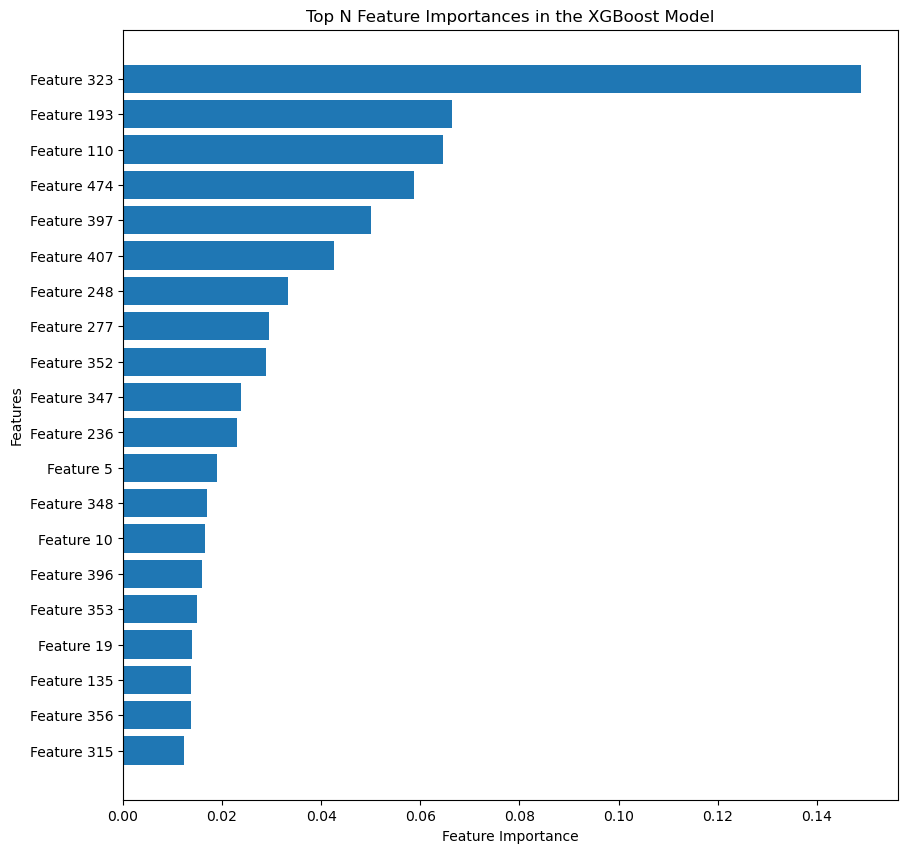

In [288]:
top_n = 20

# Getting the indices of the top N features
sorted_idx = np.argsort(feature_importances)[-top_n:]

# Creating a simplified DataFrame for the top N features
# Note: Adjust feature_names construction if you have specific names you want to use
feature_names = [f'Feature {i}' for i in range(len(feature_importances))]
top_feature_names = [feature_names[i] for i in sorted_idx]
top_feature_importances = feature_importances[sorted_idx]

# Plotting
plt.figure(figsize=(10, 10))
plt.barh(range(top_n), top_feature_importances, align='center')
plt.yticks(range(top_n), top_feature_names)
plt.title("Top N Feature Importances in the XGBoost Model")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

# Hypereparamter Optimization


In [289]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter grid
param_dist = {
    'xgbregressor__max_depth': randint(3, 10),
    'xgbregressor__min_child_weight': randint(1, 6),
    'xgbregressor__gamma': uniform(0, 0.5),
    'xgbregressor__subsample': uniform(0.5, 0.5),
    'xgbregressor__colsample_bytree': uniform(0.5, 0.5),
    'xgbregressor__lambda': uniform(1, 0),
    'xgbregressor__alpha': uniform(1, 0)
}

# Perform randomized search
search = RandomizedSearchCV(xg_pipe, param_distributions=param_dist, n_iter=100, scoring='r2', cv=5, verbose=1, n_jobs=-1, random_state=42)

search.fit(X_train, y_train)

# Best parameters and scores
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)

# Evaluate the model with the best parameters
eval_model(search.best_estimator_, X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'xgbregressor__alpha': 1.0, 'xgbregressor__colsample_bytree': 0.5126753717077288, 'xgbregressor__gamma': 0.48132420733896253, 'xgbregressor__lambda': 1.0, 'xgbregressor__max_depth': 9, 'xgbregressor__min_child_weight': 1, 'xgbregressor__subsample': 0.8442499503826832}
Best score: 0.28537870834132145


/var/folders/fy/1_r80v9j3s39nw5nw46_dw800000gq/T/ipykernel_2186/3468493226.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


fit_time       0.578 (+/- 0.064)
score_time     0.059 (+/- 0.001)
test_score     0.285 (+/- 0.142)
train_score    0.937 (+/- 0.010)
dtype: object